In [27]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import keras
import humanize
import numpy as np
from sklearn import metrics

from experimental.deeplearning.fish import train_discriminator
from experimental.deeplearning.fish.proto import fish_pb2

In [2]:
dataset_root = pathlib.Path('~/data/experimental/deeplearning/fish/assertion_dataset').expanduser()
model_path = pathlib.Path('~/data/experimental/deeplearning/fish/assertion_model').expanduser()

In [3]:
with open(model_path / 'atomizer.pkl', 'rb') as f:
    atomizer = pickle.load(f)
atomizer

AsciiCharacterAtomizer[93 chars]

In [4]:
weights = sorted([p for p in model_path.iterdir() if p.name.startswith('weights')])
print(len(weights), 'checkpoint files')

50 checkpoint files


In [5]:
model = keras.models.load_model(weights[-1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
code_in (InputLayer)         (None, 1024)              0         
_________________________________________________________________
embedding (Embedding)        (None, 1024, 64)          6016      
_________________________________________________________________
lstm_1 (LSTM)                (None, 1024, 64)          33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1024, 64)          33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total para

In [6]:
testing_protos = train_discriminator.LoadPositiveNegativeProtos(
      dataset_root / 'testing')
print('Number of testing examples:',
      humanize.intcomma(len(testing_protos.positive) +
                        len(testing_protos.negative)))

Number of testing examples: 622


In [55]:
sequence_length = 1024
x, y = train_discriminator.ProtosToModelData(testing_protos, sequence_length, atomizer)
protos = testing_protos.positive + testing_protos.negative

In [8]:
pred_y = model.predict(x)
pred_y_binary = [np.argmax(y) for y in pred_y]

In [14]:
metrics.confusion_matrix(y, pred_y_binary)

array([[302,   9],
       [ 14, 297]])

/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6444: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


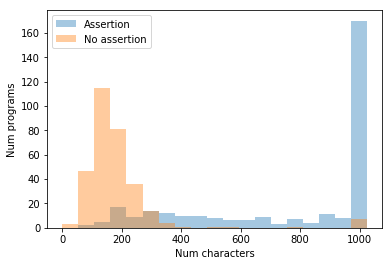

In [51]:
positive_lengths = np.array([min(len(p.src), sequence_length) for p in testing_protos.positive])
negative_lengths = np.array([min(len(p.src), sequence_length) for p in testing_protos.negative])
sns.distplot(positive_lengths, bins=np.linspace(0, 1024, 20), kde=False, label='Assertion')
sns.distplot(negative_lengths, bins=np.linspace(0, 1024, 20), kde=False, label='No assertion')
plt.xlabel('Num characters')
plt.ylabel('Num programs')
plt.legend()

In [33]:
false_negatives, false_positives = [], []
for proto, y_, pred_y_binary_ in zip(protos, y, pred_y_binary):
    if y_ and not pred_y_binary_:
        false_negatives.append(proto)
    elif not y_ and pred_y_binary_:
        false_positives.append(proto)
print(len(false_negatives), 'false negatives,', len(false_positives), 'false positives')

14 false negatives, 9 false positives


/home/linuxbrew/.linuxbrew/opt/python/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6444: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


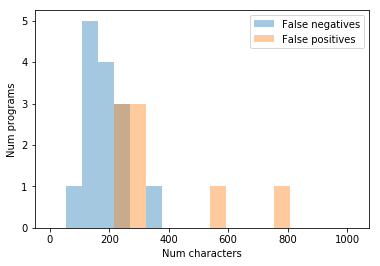

In [53]:
sns.distplot([len(p.src) for p in false_negatives], bins=np.linspace(0, 1024, 20), kde=False, label='False negatives')
sns.distplot([len(p.src) for p in false_positives], bins=np.linspace(0, 1024, 20), kde=False, label='False positives')
plt.xlabel('Num characters')
plt.ylabel('Num programs')
plt.legend()

Conclusion: The LSTM is learning to classify programs based largely on program length.